# **Train DenseNet121**
---
In this notebbok i used pretrained DenseNet121 from Keras with the same augmentations.

Summary of Results:
- Accuracy:
  - Started at 68.7% then reached 89.9% in train then 88.2% val accuracy by Epoch 10
- Loss:
  - Train loss dropped from 0.83 to 0.29 while validation loss dropped from 0.44 to 0.27

---

In [1]:
# imports
import os
import numpy as np
import tensorflow as tf
import pickle
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling, Conv2D

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# data
data_dir = 'tumor_data_cleaned'
train_dir = os.path.join(data_dir, 'Training')
val_dir = os.path.join(data_dir, 'Testing')

# augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
     validation_split=0.2 # 20% of training data for validation
)

val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#  load images 
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=8,
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=8,
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [3]:
densenet_base = DenseNet121(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)
densenet_base.trainable = False

input_layer = layers.Input(shape=(224, 224, 1))


x = layers.Concatenate()([input_layer, input_layer, input_layer])  # [224,224,1] → [224,224,3]

x = densenet_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 224, 224, 3)       │               0 │ input_layer_1[0][0],       │
│                               │                           │                 │ input_layer_1[0][0],       │
│                               │                           │                 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ densenet121 (Functional)      │ (None, 7, 7, 1024)        │       7,037,504 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 1024)              │               0 │ densenet121[0][0]          │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │         131,200 │ global_average_pooling2d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 4)                 │             516 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 7,169,220 (27.35 MB)

 Trainable params: 131,716 (514.52 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [4]:
# train model
densenet_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)

Epoch 1/10


C:\Users\eliga\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


714/714 ━━━━━━━━━━━━━━━━━━━━ 183s 247ms/step - accuracy: 0.6875 - loss: 0.8254 - val_accuracy: 0.8063 - val_loss: 0.4921
Epoch 2/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 169s 237ms/step - accuracy: 0.8425 - loss: 0.4230 - val_accuracy: 0.8444 - val_loss: 0.3889
Epoch 3/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 168s 235ms/step - accuracy: 0.8511 - loss: 0.3814 - val_accuracy: 0.8566 - val_loss: 0.3675
Epoch 4/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 169s 237ms/step - accuracy: 0.8613 - loss: 0.3847 - val_accuracy: 0.8391 - val_loss: 0.4744
Epoch 5/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 169s 236ms/step - accuracy: 0.8760 - loss: 0.3372 - val_accuracy: 0.8848 - val_loss: 0.3113
Epoch 6/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 174s 244ms/step - accuracy: 0.8796 - loss: 0.3159 - val_accuracy: 0.8757 - val_loss: 0.3412
Epoch 7/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 176s 246ms/step - accuracy: 0.8738 - loss: 0.3217 - val_accuracy: 0.8780 - val_loss: 0.3127
Epoch 8/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 174s 244ms/step - accuracy: 0.8962 - loss: 0.27

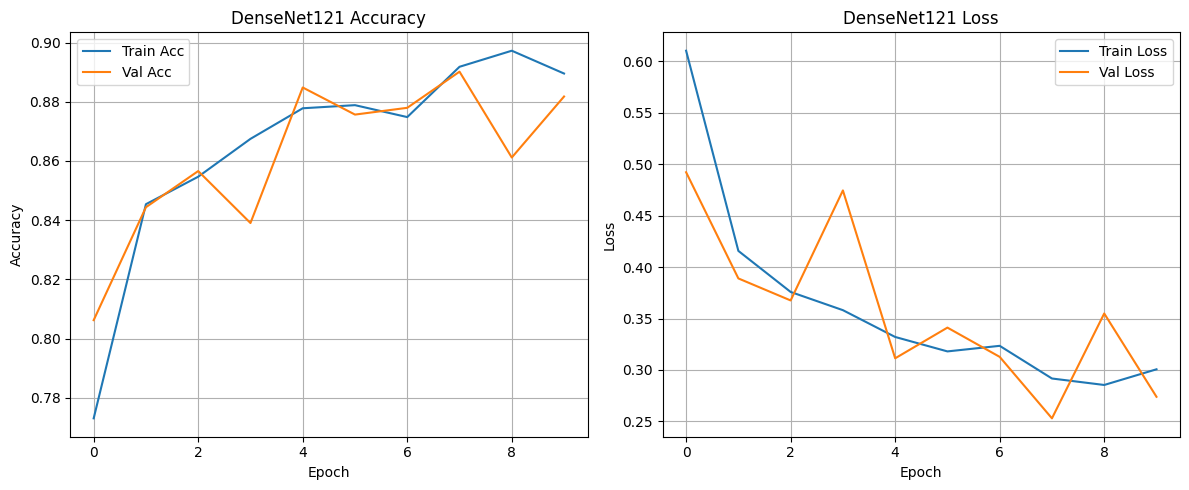

In [5]:
# plot learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(densenet_history.history['accuracy'], label='Train Acc')
plt.plot(densenet_history.history['val_accuracy'], label='Val Acc')
plt.title('DenseNet121 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(densenet_history.history['loss'], label='Train Loss')
plt.plot(densenet_history.history['val_loss'], label='Val Loss')
plt.title('DenseNet121 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('densenet121_learning_curves.png', dpi=300)
plt.show()

In [6]:
model.save("BrainTumor_DenseNet121.h5")

with open('densenet121_history.pkl', 'wb') as f:
    pickle.dump(densenet_history.history, f)